In [274]:
import numpy as np
import math
import matplotlib.pyplot as plt
from memory_profiler import memory_usage
import time

In [275]:
class BaseOptimizer:
    def __init__(self, lr, k_reg):
        self.lr = lr
        self.k_reg = k_reg

    def optimize(self, weights, loss_grad, batch_xs, batch_ys):
        gradient = loss_grad(weights, batch_xs, batch_ys).mean(axis=1)
        return weights - gradient * self.lr + self.k_reg * weights


class BatchGD:
    def __init__(self, dim, epochs, loss, loss_grad, lamb=0.4, optimizer=BaseOptimizer(1e-2, 1e-4)):
        self.dim = dim
        self.epochs = epochs
        self.weights = np.random.rand(dim)
        self.loss = loss
        self.loss_grad = loss_grad
        self.lamb = lamb
        self.optimizer = optimizer

    def train(self, xs, ys, bs, q_precision=1e-5, weights_precision=1e-4, show_loss=True):
        q = self.loss(self.weights, xs, ys).mean()
        losses = []
        for i in range(self.epochs):
            batch_idxs = np.random.choice(np.arange(len(xs)), size=bs, replace=False)
            batch_xs = xs[batch_idxs, :]
            batch_ys = ys[batch_idxs]

            eps = self.loss(self.weights, batch_xs, batch_ys).mean()
            losses.append(q)
            prev_weights = self.weights

            self.weights = self.optimizer.optimize(self.weights, self.loss_grad, batch_xs, batch_ys)

            prev_q = q
            q = self.lamb * eps + (1 - self.lamb) * prev_q

            if show_loss:
                print(f'Epoch: {i + 1}. Loss: {q}')

            if np.abs(q - prev_q) < q_precision and np.abs(self.weights - prev_weights).mean() < weights_precision:
                return losses
        return losses

    def predict(self, xs):
        return xs @ self.weights

In [276]:
f = lambda x: -5 * x[:, 0] + 3 * x[:, 1]
loss = lambda weights, xs, ys: (xs @ weights - ys) ** 2
loss_grad = lambda weights, xs, ys: np.array([2 * (xs @ weights - ys) * (xs[:, i]) for i in range(len(weights))])

In [277]:
a, b = -10, 10
xs = (b - a) * np.random.random_sample((100, 1)) + a
xs =  np.append(xs, np.ones((100, 1)), axis=1)
ys = f(xs).flatten()

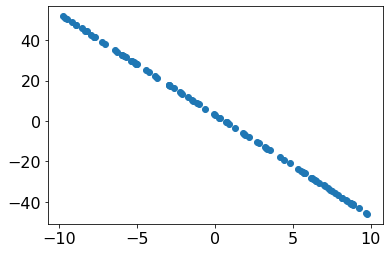

In [278]:
plt.scatter(xs[:, 0], ys)

### SGD

In [279]:
sgd_algo = BatchGD(2, 1000, loss, loss_grad)

In [280]:
sgd_losses = sgd_algo.train(xs, ys, 1)

Epoch: 1. Loss: 1471.8311576981303
Epoch: 2. Loss: 950.0946298502906
Epoch: 3. Loss: 571.3878440348775
Epoch: 4. Loss: 349.1118618104487
Epoch: 5. Loss: 210.87171234975165
Epoch: 6. Loss: 129.8534141835716
Epoch: 7. Loss: 83.09576256847635
Epoch: 8. Loss: 53.1301843900878
Epoch: 9. Loss: 32.43686974882424
Epoch: 10. Loss: 24.206489685557596
Epoch: 11. Loss: 16.1367592341388
Epoch: 12. Loss: 14.773066198447964
Epoch: 13. Loss: 8.8726582013424
Epoch: 14. Loss: 5.43067006823738
Epoch: 15. Loss: 8.14849742945939
Epoch: 16. Loss: 6.1372288922079274
Epoch: 17. Loss: 3.9301192449341995
Epoch: 18. Loss: 5.641388111135103
Epoch: 19. Loss: 4.483484825308421
Epoch: 20. Loss: 3.005779465838589
Epoch: 21. Loss: 1.8377106838050068
Epoch: 22. Loss: 1.8291310364759958
Epoch: 23. Loss: 1.240017085572334
Epoch: 24. Loss: 0.7443090589377194
Epoch: 25. Loss: 0.4726972760352597
Epoch: 26. Loss: 0.2838250059640669
Epoch: 27. Loss: 4.334725729259291
Epoch: 28. Loss: 4.647450509868271
Epoch: 29. Loss: 5.80902

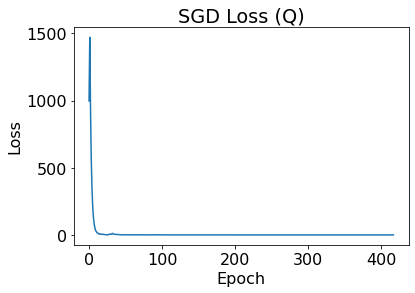

In [281]:
plt.plot(sgd_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD Loss (Q)')
plt.show()

In [282]:
preds = sgd_algo.predict(xs)

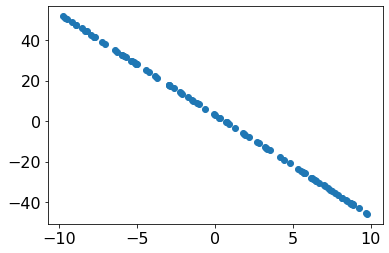

In [283]:
plt.scatter(xs[:, 0], preds)

### Minibatch (20)

In [284]:
minibatch_algo = BatchGD(2, 1000, loss, loss_grad)

In [285]:
minibatch_losses = minibatch_algo.train(xs, ys, bs=40)

Epoch: 1. Loss: 1049.7873717336734
Epoch: 2. Loss: 665.5903541024862
Epoch: 3. Loss: 401.8696713684582
Epoch: 4. Loss: 242.71483243574073
Epoch: 5. Loss: 147.06979644036358
Epoch: 6. Loss: 89.71637200483892
Epoch: 7. Loss: 55.19543689976276
Epoch: 8. Loss: 34.41206859045275
Epoch: 9. Loss: 21.90978946133022
Epoch: 10. Loss: 14.38636607538361
Epoch: 11. Loss: 9.7929858198383
Epoch: 12. Loss: 6.98989617061979
Epoch: 13. Loss: 5.27699295697192
Epoch: 14. Loss: 4.16799741718319
Epoch: 15. Loss: 3.450336564078685
Epoch: 16. Loss: 3.1205892712180843
Epoch: 17. Loss: 2.7875690032162965
Epoch: 18. Loss: 2.5537670780750896
Epoch: 19. Loss: 2.3747075262401722
Epoch: 20. Loss: 2.220452574654366
Epoch: 21. Loss: 2.13349163101282
Epoch: 22. Loss: 2.023717145587961
Epoch: 23. Loss: 1.9309834566451434
Epoch: 24. Loss: 1.8358122560039072
Epoch: 25. Loss: 1.7729622093781843
Epoch: 26. Loss: 1.6929919391844857
Epoch: 27. Loss: 1.627993447171255
Epoch: 28. Loss: 1.5647501623325166
Epoch: 29. Loss: 1.5260

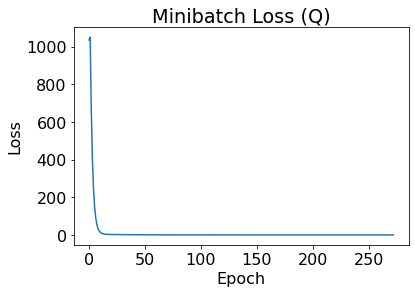

In [286]:
plt.plot(minibatch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Minibatch Loss (Q)')
plt.show()

In [287]:
preds = minibatch_algo.predict(xs)

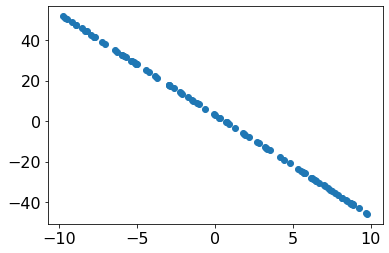

In [288]:
plt.scatter(xs[:, 0], preds)

### Batch (full dataset)

In [289]:
batch_algo = BatchGD(2, 1000, loss, loss_grad, 1.0)

In [290]:
batch_losses = batch_algo.train(xs, ys, bs=100)

Epoch: 1. Loss: 918.2557052040647
Epoch: 2. Loss: 75.28033413802964
Epoch: 3. Loss: 11.103509071984643
Epoch: 4. Loss: 6.028735777060345
Epoch: 5. Loss: 5.441644428718088
Epoch: 6. Loss: 5.2012780757612544
Epoch: 7. Loss: 4.994411204741685
Epoch: 8. Loss: 4.7973586437676055
Epoch: 9. Loss: 4.608140104244242
Epoch: 10. Loss: 4.426355470000854
Epoch: 11. Loss: 4.251713812315847
Epoch: 12. Loss: 4.0839370421220496
Epoch: 13. Loss: 3.922756521481062
Epoch: 14. Loss: 3.7679136048205653
Epoch: 15. Loss: 3.6191596280588514
Epoch: 16. Loss: 3.476255632164113
Epoch: 17. Loss: 3.338972015171202
Epoch: 18. Loss: 3.207088174447181
Epoch: 19. Loss: 3.0803921564775036
Epoch: 20. Loss: 2.958680318580397
Epoch: 21. Loss: 2.841757003381016
Epoch: 22. Loss: 2.729434225903883
Epoch: 23. Loss: 2.621531372887942
Epoch: 24. Loss: 2.5178749138726033
Epoch: 25. Loss: 2.4182981236011063
Epoch: 26. Loss: 2.3226408152999216
Epoch: 27. Loss: 2.230749084408659
Epoch: 28. Loss: 2.1424750623512585
Epoch: 29. Loss: 2

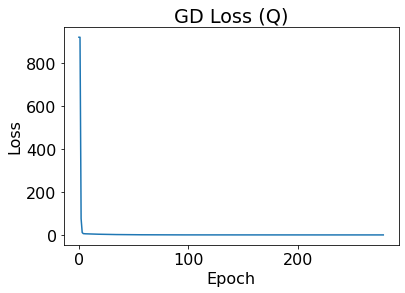

In [291]:
plt.plot(batch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GD Loss (Q)')
plt.show()

In [292]:
preds = batch_algo.predict(xs)

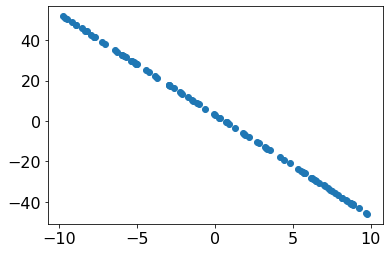

In [293]:
plt.scatter(xs[:, 0], preds)

In [294]:
scaled = xs.copy()
scaled[:, 0] = (scaled[:, 0] - scaled[:, 0].mean(axis=0)) / scaled[:, 0].std(axis=0)
ys_scaled = f(scaled).flatten()

In [295]:
sgd_algo_scaled = BatchGD(2, 1000, loss, loss_grad)
sgd_losses_scaled = sgd_algo_scaled.train(scaled, ys_scaled, 1)

Epoch: 1. Loss: 29.23404209329119
Epoch: 2. Loss: 25.061802024038684
Epoch: 3. Loss: 32.057362659797704
Epoch: 4. Loss: 39.76251126531659
Epoch: 5. Loss: 28.349691595690615
Epoch: 6. Loss: 21.619541107957648
Epoch: 7. Loss: 46.62888702804524
Epoch: 8. Loss: 63.48638694444941
Epoch: 9. Loss: 38.23756845652884
Epoch: 10. Loss: 32.12322472249589
Epoch: 11. Loss: 26.448592315929602
Epoch: 12. Loss: 28.73615163181917
Epoch: 13. Loss: 19.394355679856027
Epoch: 14. Loss: 13.639567224036435
Epoch: 15. Loss: 10.81535560432938
Epoch: 16. Loss: 12.811395939750074
Epoch: 17. Loss: 13.476631140049742
Epoch: 18. Loss: 9.577153302742236
Epoch: 19. Loss: 8.737820633550399
Epoch: 20. Loss: 6.516965363985204
Epoch: 21. Loss: 21.30016942974605
Epoch: 22. Loss: 14.941996023568345
Epoch: 23. Loss: 14.431440782365293
Epoch: 24. Loss: 28.59321108586093
Epoch: 25. Loss: 25.78162287932106
Epoch: 26. Loss: 15.520569334214585
Epoch: 27. Loss: 23.294896303807594
Epoch: 28. Loss: 19.746483421922118
Epoch: 29. Loss

Text(0.5, 1.0, 'SGD Loss (Scaled) (Q)')

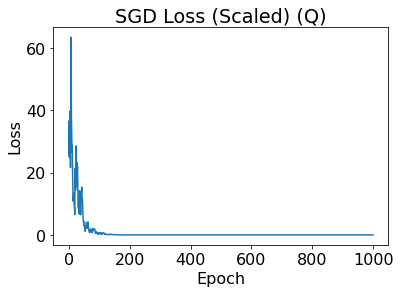

In [296]:
plt.plot(sgd_losses_scaled)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD Loss (Scaled) (Q)')

## Nesterov 

In [297]:
class NesterovOptimizer:
  def __init__(self,lr=1e-3, gamma=0.9):
    self.v = 0
    self.lr = lr
    self.gamma = gamma

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights - self.gamma * self.v, batch_xs, batch_ys).mean(axis=1)
    self.v = self.gamma * self.v + gradient * self.lr
    return weights - self.v

optimizer = NesterovOptimizer()
sgd_nesterov_algo = BatchGD(2, 1000, loss, loss_grad, lamb=0.4, optimizer=optimizer)

sgd_nesterov_losses = sgd_nesterov_algo.train(xs, ys, 1)

Epoch: 1. Loss: 1534.6537042115433
Epoch: 2. Loss: 1023.4921159766754
Epoch: 3. Loss: 934.3200444970271
Epoch: 4. Loss: 763.0642741253013
Epoch: 5. Loss: 500.0841429578613
Epoch: 6. Loss: 303.0569123550475
Epoch: 7. Loss: 181.8991026830079
Epoch: 8. Loss: 111.22557345332841
Epoch: 9. Loss: 282.2300903754133
Epoch: 10. Loss: 190.50079843474464
Epoch: 11. Loss: 205.07844205370617
Epoch: 12. Loss: 346.9290973763458
Epoch: 13. Loss: 211.4803567626123
Epoch: 14. Loss: 208.88596299308122
Epoch: 15. Loss: 133.51120251470445
Epoch: 16. Loss: 80.10717964730455
Epoch: 17. Loss: 52.326261800080474
Epoch: 18. Loss: 31.496580886851802
Epoch: 19. Loss: 23.99039740426738
Epoch: 20. Loss: 19.662510177338497
Epoch: 21. Loss: 12.107267212711138
Epoch: 22. Loss: 13.129612213107237
Epoch: 23. Loss: 35.187086038008225
Epoch: 24. Loss: 48.54937569167973
Epoch: 25. Loss: 34.71654307711667
Epoch: 26. Loss: 20.968780611427295
Epoch: 27. Loss: 13.298394561224931
Epoch: 28. Loss: 8.002832910398737
Epoch: 29. Los

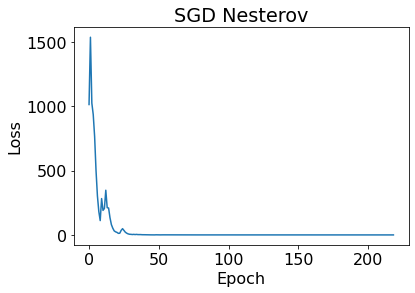

In [298]:
plt.plot(sgd_nesterov_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD Nesterov')
plt.show()

## Momentum

In [299]:
class MomentumOptimizer:
  def __init__(self,lr=1e-3, gamma=0.9):
    self.v = 0
    self.lr = lr
    self.gamma = gamma

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights, batch_xs, batch_ys).mean(axis=1)
    self.v = self.gamma * self.v + gradient * self.lr
    return weights - self.v

optimizer = MomentumOptimizer()
sgd_momentum_algo = BatchGD(2, 1000, loss, loss_grad, lamb=0.4, optimizer=optimizer)

sgd_monentum_losses = sgd_momentum_algo.train(xs, ys, 1)

Epoch: 1. Loss: 640.4130619739806
Epoch: 2. Loss: 712.4143434689566
Epoch: 3. Loss: 482.7563724238018
Epoch: 4. Loss: 450.47851289399347
Epoch: 5. Loss: 309.88025610712987
Epoch: 6. Loss: 295.9704797362457
Epoch: 7. Loss: 208.7365269169725
Epoch: 8. Loss: 182.66790716343664
Epoch: 9. Loss: 118.02261345991312
Epoch: 10. Loss: 73.74496945354792
Epoch: 11. Loss: 74.44521179886223
Epoch: 12. Loss: 67.47109432160981
Epoch: 13. Loss: 41.360120626248225
Epoch: 14. Loss: 29.633620023605417
Epoch: 15. Loss: 188.31172270049336
Epoch: 16. Loss: 267.029181860841
Epoch: 17. Loss: 258.1086508592364
Epoch: 18. Loss: 178.23034105756204
Epoch: 19. Loss: 107.09843480663554
Epoch: 20. Loss: 66.55918761547969
Epoch: 21. Loss: 53.01307352417515
Epoch: 22. Loss: 42.038043208410166
Epoch: 23. Loss: 118.5181835979535
Epoch: 24. Loss: 113.5080810679731
Epoch: 25. Loss: 81.82399002378082
Epoch: 26. Loss: 101.81528493372156
Epoch: 27. Loss: 61.12359706487783
Epoch: 28. Loss: 41.03573140558767
Epoch: 29. Loss: 27

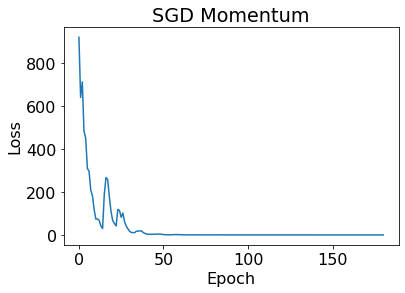

In [300]:
plt.plot(sgd_monentum_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD Momentum')
plt.show()

## AdaGrad

In [301]:
%%time
class AdaGradOptimizer:
  def __init__(self,lr=9e-1, eps = 1e-8):
    self.G = 0
    self.lr = lr
    self.eps = eps

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights, batch_xs, batch_ys).mean(axis=1)
    self.G += gradient ** 2
    return weights - self.lr * gradient / np.sqrt(self.G + self.eps)

optimizer = AdaGradOptimizer()
sgd_adagrad_algo = BatchGD(2, 20000, loss, loss_grad, lamb=0.8, optimizer=optimizer)

sgd_adagrad_losses = sgd_adagrad_algo.train(xs, ys, 1)

Epoch: 1. Loss: 587.3959255123148
Epoch: 2. Loss: 421.4588700527622
Epoch: 3. Loss: 1132.88509132262
Epoch: 4. Loss: 538.8744697927267
Epoch: 5. Loss: 194.4597982122453
Epoch: 6. Loss: 502.58215436533726
Epoch: 7. Loss: 330.73041492478785
Epoch: 8. Loss: 192.48928730197449
Epoch: 9. Loss: 352.6674997417734
Epoch: 10. Loss: 373.7628780840595
Epoch: 11. Loss: 231.32397038476
Epoch: 12. Loss: 54.66561229981191
Epoch: 13. Loss: 68.93074977479995
Epoch: 14. Loss: 23.283426689487793
Epoch: 15. Loss: 105.83445893974334
Epoch: 16. Loss: 34.14005090586667
Epoch: 17. Loss: 64.45241904344999
Epoch: 18. Loss: 73.0857868690583
Epoch: 19. Loss: 28.800093747395792
Epoch: 20. Loss: 122.82910136908644
Epoch: 21. Loss: 65.95563733041612
Epoch: 22. Loss: 23.1573871006428
Epoch: 23. Loss: 16.86988123522659
Epoch: 24. Loss: 42.75044258047409
Epoch: 25. Loss: 8.732989180761523
Epoch: 26. Loss: 54.795852301868834
Epoch: 27. Loss: 47.769751984317466
Epoch: 28. Loss: 9.861773818931947
Epoch: 29. Loss: 25.31557

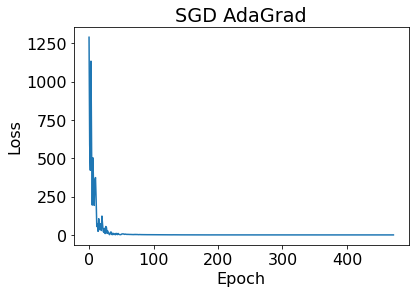

In [302]:
plt.plot(sgd_adagrad_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD AdaGrad')
plt.show()

## RMSProp

In [303]:
%%time
class RMSPropOptimizer:
  def __init__(self,lr=1e-1, eps = 1e-7, gamma=0.9):
    self.G = 0
    self.lr = lr
    self.eps = eps
    self.gamma = gamma

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights, batch_xs, batch_ys).mean(axis=1)
    self.G = self.G * self.gamma + (1 - self.gamma) * (gradient ** 2)
    return weights - self.lr * gradient / np.sqrt(self.G + self.eps)

optimizer = RMSPropOptimizer()
sgd_rmsprop_algo = BatchGD(2, 20000, loss, loss_grad, lamb=0.4, optimizer=optimizer)

sgd_rmsprop_losses = sgd_rmsprop_algo.train(xs, ys, 1)

Epoch: 1. Loss: 1561.5219917350664
Epoch: 2. Loss: 1654.007841259006
Epoch: 3. Loss: 1624.2942113709917
Epoch: 4. Loss: 1399.6028414818934
Epoch: 5. Loss: 840.3064756873258
Epoch: 6. Loss: 523.8971674661091
Epoch: 7. Loss: 344.0315985383933
Epoch: 8. Loss: 206.58556415804227
Epoch: 9. Loss: 378.18768674816715
Epoch: 10. Loss: 228.38550967332458
Epoch: 11. Loss: 836.3561000067656
Epoch: 12. Loss: 503.5763139145731
Epoch: 13. Loss: 727.9001839978501
Epoch: 14. Loss: 459.33282388850955
Epoch: 15. Loss: 865.7716917640973
Epoch: 16. Loss: 703.6945420704784
Epoch: 17. Loss: 540.8812791327372
Epoch: 18. Loss: 625.6277430123639
Epoch: 19. Loss: 862.8272877555894
Epoch: 20. Loss: 708.5120628449422
Epoch: 21. Loss: 935.340524175051
Epoch: 22. Loss: 562.2230258796444
Epoch: 23. Loss: 588.4806840898414
Epoch: 24. Loss: 462.17424959203316
Epoch: 25. Loss: 369.28023484308477
Epoch: 26. Loss: 221.75768203902626
Epoch: 27. Loss: 402.1437637778453
Epoch: 28. Loss: 246.2272667399024
Epoch: 29. Loss: 247

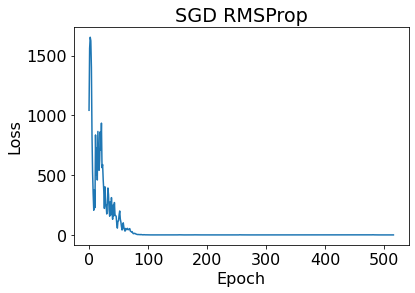

In [304]:
plt.plot(sgd_rmsprop_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD RMSProp')
plt.show()

## Adam

In [305]:
%%time
class AdamOptimizer:
  def __init__(self,lr=1e-2, eps = 1e-7, b_1=0.5, b_2=0.5):
    self.G = 0
    self.lr = lr
    self.eps = eps
    self.b_1 = b_1
    self.b_2 = b_2

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights, batch_xs, batch_ys).mean(axis=1)

    self.m = self.G * self.b_1 + (1 - self.b_1) * gradient
    self.v = self.G * self.b_2 + (1 - self.b_2) * (gradient ** 2)

    return weights - self.lr * self.m / np.sqrt(self.v + self.eps)

optimizer = AdamOptimizer()
sgd_adam_algo = BatchGD(2, 10000, loss, loss_grad, lamb=0.4, optimizer=optimizer)

sgd_adam_losses = sgd_adam_algo.train(xs, ys, 1)

Epoch: 1. Loss: 1183.3013230702102
Epoch: 2. Loss: 1142.922092759829
Epoch: 3. Loss: 761.724064957962
Epoch: 4. Loss: 1168.9693466053877
Epoch: 5. Loss: 1614.671225319441
Epoch: 6. Loss: 1522.7978583306758
Epoch: 7. Loss: 1415.1583228276531
Epoch: 8. Loss: 1355.7349481820647
Epoch: 9. Loss: 1345.2394474947855
Epoch: 10. Loss: 807.1633731490807
Epoch: 11. Loss: 1577.8825529168369
Epoch: 12. Loss: 1396.6287211277072
Epoch: 13. Loss: 960.9009547700578
Epoch: 14. Loss: 1058.6501732340687
Epoch: 15. Loss: 1176.3319438246729
Epoch: 16. Loss: 708.22406903306
Epoch: 17. Loss: 426.51840755660743
Epoch: 18. Loss: 649.1573170878155
Epoch: 19. Loss: 471.01366901358006
Epoch: 20. Loss: 725.6718708860074
Epoch: 21. Loss: 1103.8000004160579
Epoch: 22. Loss: 883.7875072706142
Epoch: 23. Loss: 675.8104965198968
Epoch: 24. Loss: 791.0812326503731
Epoch: 25. Loss: 1336.0145622145187
Epoch: 26. Loss: 908.2931101920949
Epoch: 27. Loss: 1202.2260855433437
Epoch: 28. Loss: 1327.4418723543117
Epoch: 29. Loss:

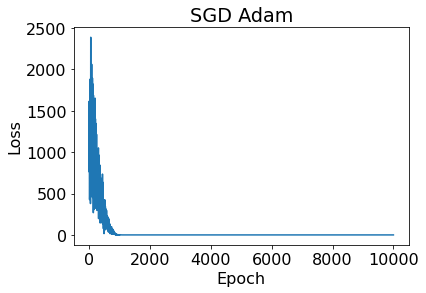

In [306]:
plt.plot(sgd_adam_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD Adam')
plt.show()

## Сравнение алгоритмов

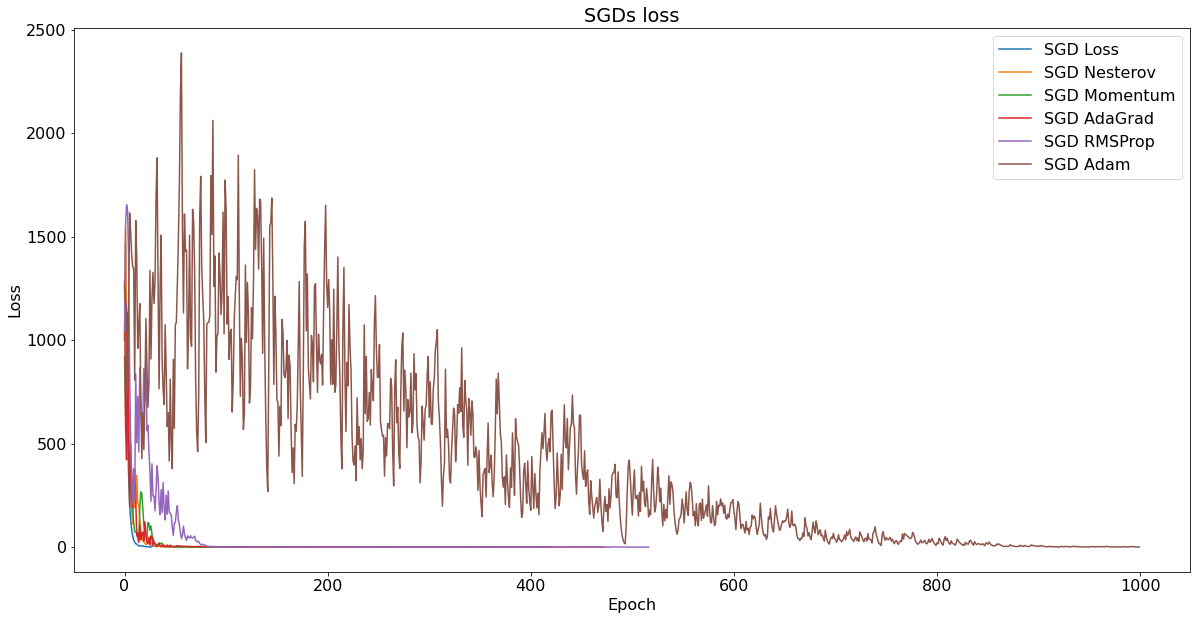

In [307]:
plt.figure(figsize=(20, 10))
plt.plot(sgd_losses, label='SGD Loss')
plt.plot(sgd_nesterov_losses, label='SGD Nesterov')
plt.plot(sgd_monentum_losses, label='SGD Momentum')
plt.plot(sgd_adagrad_losses, label='SGD AdaGrad')
plt.plot(sgd_rmsprop_losses, label='SGD RMSProp')
plt.plot(sgd_adam_losses[0:1000], label='SGD Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGDs loss')
plt.legend()
plt.show()

count iterations : [418, 219, 181, 473, 517, 1000]
used memory : [252.91796875, 252.91796875, 252.91796875, 252.91796875, 252.91796875, 252.91796875]
work time : [0.5675139427185059, 0.912761926651001, 0.903083086013794, 0.8940989971160889, 0.8760840892791748, 0.0007119178771972656]


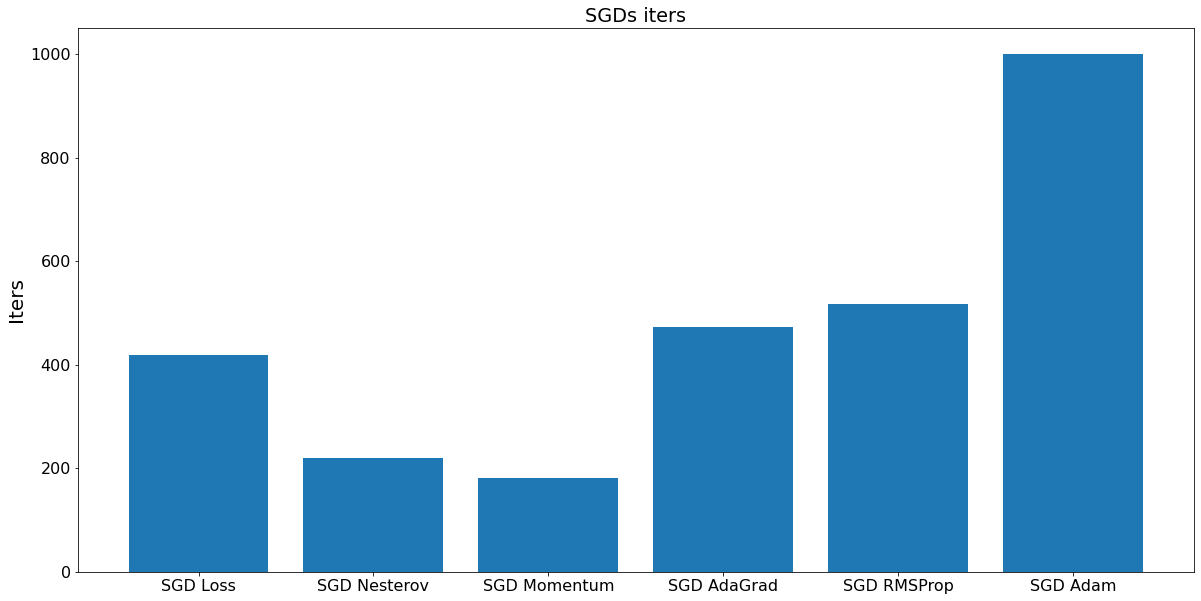

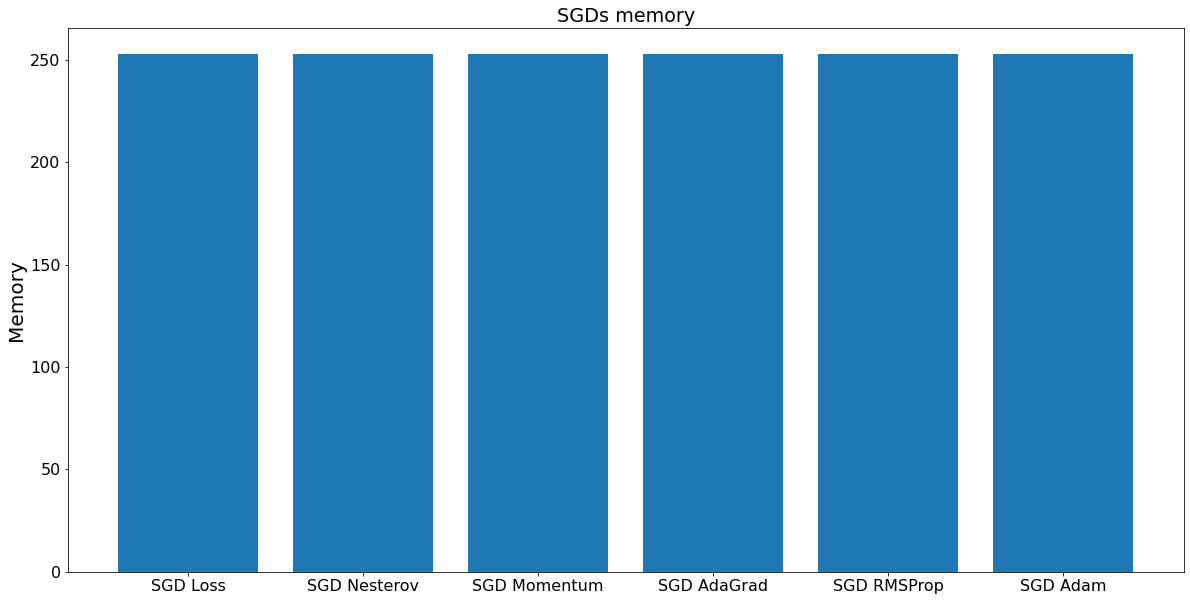

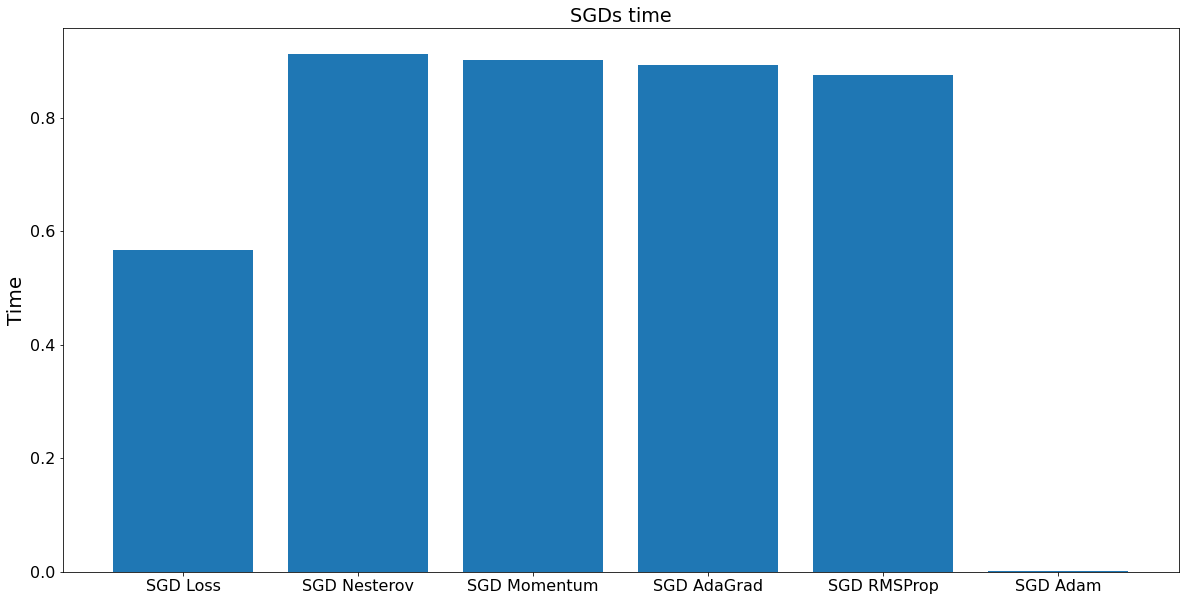

In [308]:
algos_names = ['SGD Loss', 'SGD Nesterov', 'SGD Momentum', 'SGD AdaGrad', 'SGD RMSProp', 'SGD Adam']
count_iters = [len(sgd_losses), len(sgd_nesterov_losses), len(sgd_monentum_losses), len(sgd_adagrad_losses),
               len(sgd_rmsprop_losses), len(sgd_adam_losses[0:1000])]
algos = [sgd_algo, sgd_nesterov_algo, sgd_momentum_algo, sgd_adagrad_algo, sgd_rmsprop_algo, sgd_adam_algo]
memories = []
times = []
for algo in algos:
    cur_time = time.time()
    (memory, exe_time) = memory_usage((algo.train, (xs, ys, 1,), {'show_loss': False}), timestamps=True)[0]
    memories.append(memory)
    times.append(exe_time - cur_time)

plt.rcParams.update({'font.size': 16})

print('count iterations : ' + str(count_iters))
print('used memory : ' + str(memories))
print('work time : ' + str(times))

plt.figure(figsize=(20, 10))
plt.title('SGDs iters')
plt.ylabel('Iters', fontsize=20)
plt.bar(algos_names, count_iters)
plt.show()

plt.figure(figsize=(20, 10))
plt.title('SGDs memory')
plt.ylabel('Memory', fontsize=20)
plt.bar(algos_names, memories)
plt.show()

plt.figure(figsize=(20, 10))
plt.title('SGDs time')
plt.ylabel('Time', fontsize=20)
plt.bar(algos_names, times)
plt.show()